## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project, we will be working to understand the results of an A/B test run by an e-commerce website. Analysis will consist of comparing the conversion rate of both the old and the new page based on control or treatment groups. Then the analysis will look at how the old and new pages performed by countries.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
prop_users_converted = df.query('converted == 1').count()/df.shape[0]
print(prop_users_converted['user_id'] * 100)

11.96591935560551


e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df_treatment = df.query('group == "treatment"')
df_treatment_old = df_treatment.query('landing_page == "old_page"')
df_treatment_old.shape[0]

1965

f. Do any of the rows have missing values?

In [7]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df.query('(group == "treatment" & landing_page != "old_page") | (group == "control" & landing_page != "new_page")')
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.duplicated(subset=['user_id'])]['user_id'].unique()

array([773192], dtype=int64)

c. What is the row information for the repeat **user_id**? 

In [12]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2 = df2.drop_duplicates(subset=['user_id']) \
        .reset_index(drop=True) \
        .copy()

df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1876,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2[df2['group'] == 'control']['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2[df2['group'] == 'treatment']['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
len(df2.query('landing_page == "new_page"')) / df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Probablity Conclusion: Does new treatment page lead to more conversions?.**

The probability of an individual converting in the `control` group is 12.04%. The probability of an individual converting in the `treatment` group is 11.88% which is lower than the `control` group. Combined with the fact that the probability that an indvidual received the new page is 50.00% this would lead me to conclude that the new treatment page does not lead to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

H<sub>0</sub> = p<sub>new</sub> - p<sub>old</sub> <= 0

H<sub>1</sub> = p<sub>new</sub> - p<sub>old</sub> > 0

The null hypothesis is that the converted rate for the new page is equal to or less than the converted rate for the old page. While the alternative hypothesis is that the converted rate for the new page is greater than the converted rate for the old page.


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [18]:
p_new = df2['converted'].mean()
print(p_new)

0.11959708724499628


b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old = df2['converted'].mean()
print(p_old)

0.11959708724499628


c. What is $n_{new}$, the number of individuals in the treatment group?

In [20]:
n_new = df2[df2.group == 'treatment'].shape[0]
print(n_new)

145310


d. What is $n_{old}$, the number of individuals in the control group?

In [21]:
n_old = df2[df2.group == 'control'].shape[0]
print(n_old)

145274


e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
"""
Simulating conversion rate of new page using the treatment group
0 = not converted
1 = converted
size = number of individuals in the treatment group
p = weighted probability where p(0) = (1 - p(new)) and p(1) = p(new)
"""
new_page_converted = np.random.choice([0,1], size=n_new, p=[(1 - p_new), p_new])
new_page_converted.mean() # Check conversion rate simulation

0.1203289518959466

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
"""
Simulating conversion rate of new page using the control group
0 = not converted
1 = converted
size = number of individuals in the control group
p = weighted probability where p(0) = (1 - p(old)) and p(1) = p(old)
"""
old_page_converted = np.random.choice([0,1], size=n_old, p=[(1 - p_old), p_old])
old_page_converted.mean() # Check conversion rate simulation

0.121308699423159

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
p_sim_diff = new_page_converted.mean() - old_page_converted.mean()
print(p_sim_diff)

-0.0009797475272124018


h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [25]:
p_diffs = [] # Create empty array to store diff values from simulation

# Adding the differences of the 10,000 simulations to the p_diffs array
p_diffs.append(
    # n_new and n_old are the number of occurances, p_new and p_old are the succes rate
    (np.random.binomial(n_new, p_new, 10000) / n_new) - (np.random.binomial(n_old, p_old, 10000) / n_old)
)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

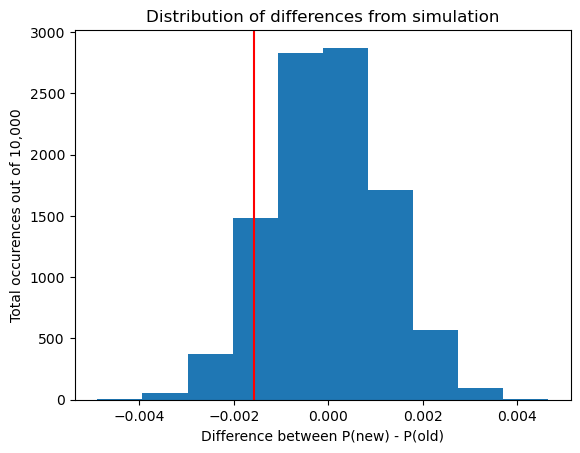

In [26]:
# Calculate observed difference from data
obs_diff = df2[df2['group'] == 'treatment']['converted'].mean() - df2[df2['group'] == 'control']['converted'].mean()
# Plot histogram
plt.hist(p_diffs) # Shows all p_diffs from the 10,000 simulations. Shows as normal distrubition as expected
plt.axvline(x=obs_diff, color='red'); # Shows the observed difference on plot
plt.title('Distribution of differences from simulation')
plt.xlabel('Difference between P(new) - P(old)')
plt.ylabel('Total occurences out of 10,000');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
# Find p_value where the p_diffs are greater than the observed statistic
p_value = (p_diffs > obs_diff).mean() # Less than 0.05 we can reject null hypothesis, otherwise fail to reject null hypothesis
print(p_value)

0.9049


k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

The p-value is the probability of getting a result equal or more extreme than the observed statistic. The closer to 0 the p-value is, the more statistically significant the results are. The closer to 1 the p-value is, the less statistically signficant the results are. 

Therefore, with the `p_value` from above and based on the Type 1 error rate of 0.05 it means that there is no statistically signficant difference between the new and old pages and we should fail to reject the null hypothesis.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [28]:
import statsmodels.api as sm

# Total number of conversions for the control group
convert_old = df2.query('group == "control" & converted == 1').shape[0]
# Total number of conversion for the treatment group
convert_new = df2.query('group == "treatment" & converted == 1').shape[0]
# Total number of rows associated with the old page regardless of conversion (variable already existed from earlier work)
n_old
# Total number of rows associated with the new page regardless of conversion (variable already existed from earlier work)
n_new

# Confirm values for variables above
print(f'Control group conversions: {convert_old}')
print(f'Treatment group conversions: {convert_new}')
print(f'Total rows for the old page: {n_old}')
print(f'Total rows for the new page: {n_new}')

Control group conversions: 17489
Treatment group conversions: 17264
Total rows for the old page: 145274
Total rows for the new page: 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [29]:
# Test for proportions based on normal (z) test
count = np.array([convert_new, convert_old]) # Number of successes in nobs trials for each independent sample
nobs = np.array([n_new, n_old]) # Number of trials/observations
z_score, p_val = sm.stats.proportions_ztest(count, nobs, alternative='larger')
print(f'The z-score is {z_score:.3f}')
print(f'The p-value is {p_val:.3f}')

The z-score is -1.311
The p-value is 0.905


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The `p_val` provided by `stats.proportions_ztest` is within 0.007 of the `p_value` I calculated above. This p-value also indicates that we should fail to reject the null hypothesis and continue to use the old page.

The z-score represents how the observed value relates to the mean of the null and alternative hypotheses. It is measured in terms of standard deviations from the mean. Therefore, the `z_score` of -1.311 shows that the observed statistic is 1.311 standard deviations _below_ the mean. This aligns with the histogram plotted above. 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic regression will be used in this part because there are only two possible outcomes. Linear regression is used to predict continous variables. For this case our null and alternative hypothseses are focused on if the new page conversion rate is higher than the old page conversion rate, which is either True or False.d.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [30]:
# Create intercept column since statsmodels does not add this for us
df2['intercept'] = 1

"""
Use get_dummies() on group column so that 1 if control and 0 when treatment will go into the old column
The new column will be the opposite of this
NOTE: get_dummies() returns True or False by default so to avoid any potential issues we explicity make the dtype an int
"""
df2[['old', 'new']] = pd.get_dummies(df2['group'], dtype=int)

# Dropping the old column from the dataset since it is just the opposite of the new column but has the same meaning essentially
df2 = df2[['user_id', 'timestamp', 'group', 'landing_page', 'converted',
           'intercept', 
           # 'old', 
           'new'
         ]].copy()

# Rename the the new column to be ab_page
df2 = df2.rename(columns={'new': 'ab_page'})

"""
Check that the changes are correct
We expect intercept column with all values equal to 1. 
We expect the ab_page column to have a 0 if the group is control and a 1 if the group is treatment
"""
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [31]:
# Instantiate a Logistic regression linear model
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

# Fit the model and store results
results = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [32]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 09 Jan 2024   Pseudo R-squ.:               8.077e-06
Time:                        15:07:58   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [33]:
np.exp(-0.0150)

0.9851119396030626

In [34]:
1/np.exp(-0.0150)

1.015113064615719

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

The p-value associated with `ab_page` is 0.190 with the logistic regression model. Whereas in part 2 the p-value was ~0.91. 

In Part II our hypothesis testing was focused on whether p(new) was greater than or equal to p(old). The observed difference was lower than the mean of the null hypthesis and therefore the p-value stated that the observed difference was not statistically signficant. 

However, when we perform hypothesis tests for the coefficients in linear models, we are testing if p(new) is the same as p(old)ata.).

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

There are a lot of factors that could influence whether an individual converts that have not been considered. How long a visitor spent on the site could be considered. Price is another factor that can influence whether an individual converts and whether there was a promotion or referral links used to drive an individual to the page. The location of the individual could also be considered to see if more individuals from a specific country or more focused geographical region are more likely to convert. These could be helpful in reducing bias in the regression model when it just limited to one variable.

Adding additional terms into the regression model can also come with some disadvantages so it will be important to choose additional terms with care. Other terms introduced could also be multicollinear with each other which means they impact each other while also impacting the variable of interest. Additional terms could also make the model harder to adjust with new data in the future which would require a new model to be fit and then unable to compare results over time.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [35]:
# Read in countries dataset
countries = pd.read_csv('countries.csv')
# Set index for countries dataset to user_id and join both dataframes on user_id
df2 = df2.join(countries.set_index('user_id'), on='user_id')
# Check that the join worked
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [36]:
df2['country'].value_counts()

country
US    203619
UK     72466
CA     14499
Name: count, dtype: int64

CA will be the baseline when fitting the logistic regression model.

In [37]:
"""
Use get_dummies() on country column
Results are returned in alphabetical order so:
    CA column will have 1 only when country is CA and 0 for everything else
    UK column will have 1 only when country is UK and 0 for everything else
    US column will have 1 only when country is US and 0 for everything else
NOTE: get_dummies() returns True or False by default so to avoid any potential issues we explicity make the dtype an int
"""
df2[['CA', 'UK', 'US']] = pd.get_dummies(df2['country'], dtype=int)

In [38]:
us_conversion = df2[df2['US'] == 1]['converted'].mean()
uk_conversion = df2[df2['UK'] == 1]['converted'].mean()
ca_conversion = df2[df2['CA'] == 1]['converted'].mean()

print(f'Conversion rate for US is: {us_conversion}')
print(f'Conversion rate for UK is: {uk_conversion}')
print(f'Conversion rate for CA is: {ca_conversion}')

Conversion rate for US is: 0.1195468006423762
Conversion rate for UK is: 0.12059448568984076
Conversion rate for CA is: 0.11531829781364232


In [39]:
# Instantiate a Logistic regression linear model
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'US', 'UK']])

# Fit the model and store results
results = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [40]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 09 Jan 2024   Pseudo R-squ.:               2.323e-05
Time:                        15:07:59   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

The country does not appear to have an impact on the conversion since the aggregated conversion rate is ~0.1196 and all three countries are close to this same conversion rate. While the conversion rate for CA is lower than the other two countries, the sample size is also much smaller. The p-values for the US and the UK are not within our Type 1 error of 0.05 to mean there is a statistical significance.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [41]:
# US user got new page = 1; old page = 0 and store in new column
df2['ab_us'] = df2['US'] * df2['ab_page']
# UK user got new page = 1; old page = 0 and store in new column
df2['ab_uk'] = df2['UK'] * df2['ab_page']
# CA user got new page = 1; old page = 0 and store in new column
df2['ab_ca'] = df2['CA'] * df2['ab_page']

In [42]:
# Check that new columns are added
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,ab_us,ab_uk,ab_ca
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0,0


In [44]:
# Functions to find conversion rates for old and new pages
def get_old_cr(data, col):
    return data[data[col] == 0]['converted'].mean()

def get_new_cr(data, col):
    return data[data[col] == 1]['converted'].mean()

In [45]:
# Get conversion rates for old and new pages for US
us_old_cr = get_old_cr(df2, 'ab_us')
us_new_cr = get_new_cr(df2, 'ab_us')

# Get conversion rates for old and new pages for UK
uk_old_cr = get_old_cr(df2, 'ab_uk')
uk_new_cr = get_new_cr(df2, 'ab_uk')

# Get conversion rates for old and new pages for CA
ca_old_cr = get_old_cr(df2, 'ab_ca')
ca_new_cr = get_new_cr(df2, 'ab_ca')

In [50]:
print(f'US Conversion rates:')
print(f'New page: {us_new_cr}')
print(f'Old page: {us_old_cr}')
print(f'Difference: {us_new_cr - us_old_cr}')
print(f'-----------------------------------')
print(f'UK Conversion rates:')
print(f'New page: {uk_new_cr}')
print(f'Old page: {uk_old_cr}')
print(f'Difference: {uk_new_cr - uk_old_cr}')
print(f'-----------------------------------')
print(f'CA Conversion rates:')
print(f'New page: {ca_new_cr}')
print(f'Old page: {ca_old_cr}')
print(f'Difference: {ca_new_cr - ca_old_cr}')

US Conversion rates:
New page: 0.11846559963887227
Old page: 0.12020818206390681
Difference: -0.0017425824250345417
-----------------------------------
UK Conversion rates:
New page: 0.1211709965102753
Old page: 0.11937377690802348
Difference: 0.0017972196022518205
-----------------------------------
CA Conversion rates:
New page: 0.11190247911245035
Old page: 0.11979539894734241
Difference: -0.007892919834892057


We can see that the new page has a slightly worse conversion rate in both US and CA. UK shows a ~0.0018 improved conversion with the new page which is minimal improvement.

In [51]:
# Instantiate a Logistic regression linear model (keeping CA as the baseline)
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'US', 'UK', 'ab_us', 'ab_uk']])

# Fit the model and store results
results = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [52]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 09 Jan 2024   Pseudo R-squ.:               3.482e-05
Time:                        15:19:22   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
ab_us          0.0469      0.054      0.872      0.383      -0.059       0.152
ab_uk          0.0783      0.057      1.378      0.168      -0.033       0.190
==============================================================================
"""

### Conclusion

This statistical summary shows the p-values are outside our Type 1 error of 0.05 and therefore are not statistically significant.

Based on all the statistical analysis conducted I have to fail to reject the null hypothesis and recommend that the old page remain in place for all countries. This analysis was limited by the amount of variables to test against and would recommend including some additional data for future models to improve the analysis.